In [1]:
import matplotlib.pyplot as plt
import pickle, os, sys
from XANES2020_code.Espec import espec_processing 
from XANES2020_code import mirage_analysis
from XANES2020_code.general_tools import imagesc

# you need to set this to the path to your data folder 
# which should have the same strucutre as on the Box for everything to work
BASE_PATH =r'/Users/streeter/BoxSync/Experiments/GeminiXANES2020/MIRAGE/'
mirage_analysis.configure(BASE_PATH)


# Electron spectrometer analysis

In [2]:
# paths for image warp and dispersion calibrations files
tForm_filepath = 'XANES2020_code/Espec/Espec_high_transform_20200829.pkl'
Espec_cal_filepath = 'XANES2020_code/Espec/Espec_high_disp_cal_20200829.mat'
# Setup analysis object which stores the relavant meta data and contains functions to run on the espec files
eSpec_proc = espec_processing.ESpec_high_proc(tForm_filepath,Espec_cal_filepath,
                             img_bkg=None,use_median=True,kernel_size=None )


## Using mirage pipelines to analysis whole runs in one go

In [3]:
# I'm using the package Stephen wrote to handle the file paths and everything
# I've slightly modified it to work for single shot mode (which is what we are mostly using) 
# The first argument is the diagnostic name, the second is the function to run on the raw data
# The third argument is how to handle bursts (not used for single shot mode)
# The actual file opening is handled using functions defined in mirage_analysis.loader and is
#  specified per diagnostic in the mirage.__init__.py file 
#  e.g. 
#  register_data_loader('ESpec_high', ImageDataLoader)
#  where the first argument is diagnostic name 
#  and the second is the function that takes a file path and returns the raw data
espec_pC_pipeline = mirage_analysis.DataPipeline('ESpec_high', 
                                                  eSpec_proc.total_charge, None,
                                                  single_shot_mode=True)

espec_W_b_pipeline = mirage_analysis.DataPipeline('ESpec_high', 
                                                  eSpec_proc.total_beam_energy, None,
                                                  single_shot_mode=True)


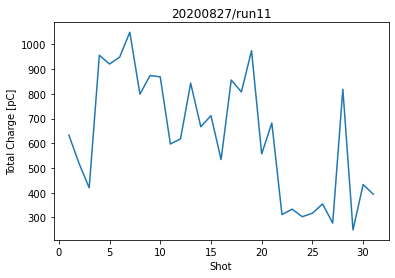

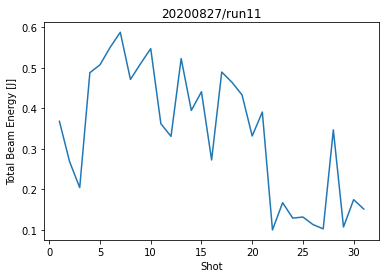

In [13]:
# the pipelines are run on a particular data run as shown below

run_name = r'20200827/run09'
run_name = r'20200827/run11'
# run_name = r'20200827/run12'
# run_name = r'20200903/run01'
# run_name = r'20200903/run04'
shot_num, espec_pC = espec_pC_pipeline.run(run_name,use_pandas=False)


plt.figure()
plt.plot(shot_num,espec_pC)
plt.xlabel('Shot')
plt.ylabel('Total Charge [pC]')
plt.title(run_name)
plt.savefig(r'plots/ESpec_high/' + run_name.replace(r'/','_') + '_total_charge.png')

shot_num, espec_pC = espec_W_b_pipeline.run(run_name,use_pandas=False)
plt.figure()
plt.plot(shot_num,espec_pC)
plt.xlabel('Shot')
plt.ylabel('Total Beam Energy [J]')
plt.title(run_name)
plt.savefig(r'plots/ESpec_high/' + run_name.replace(r'/','_') + '_total_beam_energy.png')

## Analyse individual shots
You don't have to use mirage, you can use the analysis function on individual shots with your own code

In [11]:
# convert particular file into a spectrum
img_raw = plt.imread(os.path.join(BASE_PATH,r'Espec_high/20200827/run12/Shot007.tif'))
img_pC_permm2 = eSpec_proc.espec_data2screen(img_raw)
spec_pC_per_mm_per_MeV = eSpec_proc.espec_screen2spec(img_pC_permm2)                 



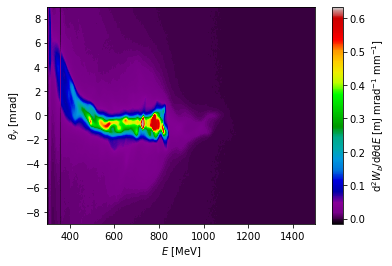

In [12]:
# display the energy per MeV per mrad
plt.figure()
ax = plt.axes()
screen_dist_m = 1.48
y_mrad = (eSpec_proc.screen_y_mm-38)/screen_dist_m
spec_mJ_per_mrad_per_MeV = spec_pC_per_mm_per_MeV*eSpec_proc.eAxis_MeV*screen_dist_m*1e-3
ih = imagesc(spec_mJ_per_mrad_per_MeV,
             x=eSpec_proc.eAxis_MeV,y=y_mrad,
             ax=ax,cmap='nipy_spectral',vmax=None)
plt.xlabel(r'$E$ [MeV]')
plt.ylabel(r'$\theta_y$ [mrad]')
plt.ylim((-9,9))

cb = plt.colorbar(ih,ax=ax)
cb.set_label(r'd$^2W_b$/d$\theta$d$E$ [mJ mrad$^{-1}$ mm$^{-1}$]')